# 1. Modules

## 1.1. Load basics

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

## 1.2. Load library modules

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.transformation.Bxyz2Jxy import Bxyz2Jxy
from magrec.transformation.Bsensor2Jxy import Bsensor2Jxy
from magrec.misc.data import Data
from magrec import __datapath__

# 2. Data

## 2.1. Load Data¶

We'll be working with the Nb wire dataset, which has three components of the magnetic field known, and known simulated NV orientation angle. There's also a plausible reconstruction available in the notebook `Test_Magnetic_Field_Recon.ipynb`. The goal of this notebook is to achieve a similar or better performance by optimization.

First we load the data and look at what we want to reconstruct the current from:

In [4]:
Bx = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "Bz.txt")

B = np.empty(shape=(3, 201, 201))

sensor_theta = np.deg2rad(54.7)
sensor_phi = np.deg2rad(45)

unv = [np.sin(sensor_theta) * np.cos(sensor_phi),
       np.sin(sensor_theta) * np.sin(sensor_phi),
       np.cos(sensor_theta)]

B[0, :, :] = 1e-4*(np.rot90(Bx))
B[1, :, :] = 1e-4*(np.rot90(By))
B[2, :, :] = 1e-4*(np.rot90(Bz))
Bsensor = np.flipud(Bx*unv[0] + By*unv[1] + Bz*unv[2])

sensor_theta = 0
sensor_phi = 0 

dx = 0.4
dy = 0.4
height = 0.1
thickness = 0.1

dataset = Data()
dataset.load_data(
       B, 
       dx, 
       dy, 
       height, 
       sensor_theta, 
       sensor_phi, 
       thickness)

dataset.remove_DC_background()
dataset.add_hanning_filter(1)

# dataset.crop_data((1,198,1,198))
# dataset.pad_data_to_power_of_two()
# dataset.pad_reflective2d()
# dataset.plot_target()

In [5]:
# check the actions that have been applied to the dataset
dataset.actions

,action type,reverseable,reverse action,description,parameters
0,load_data,False,None,loaded the data,None
1,remove_DC_background,False,None,Removed the DC background from the data,None
2,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 1


In [6]:
print(len(dataset.target.size()))

3


## Reconstruct the current density using a neural network using Bz data

[30, 226, 30, 226]


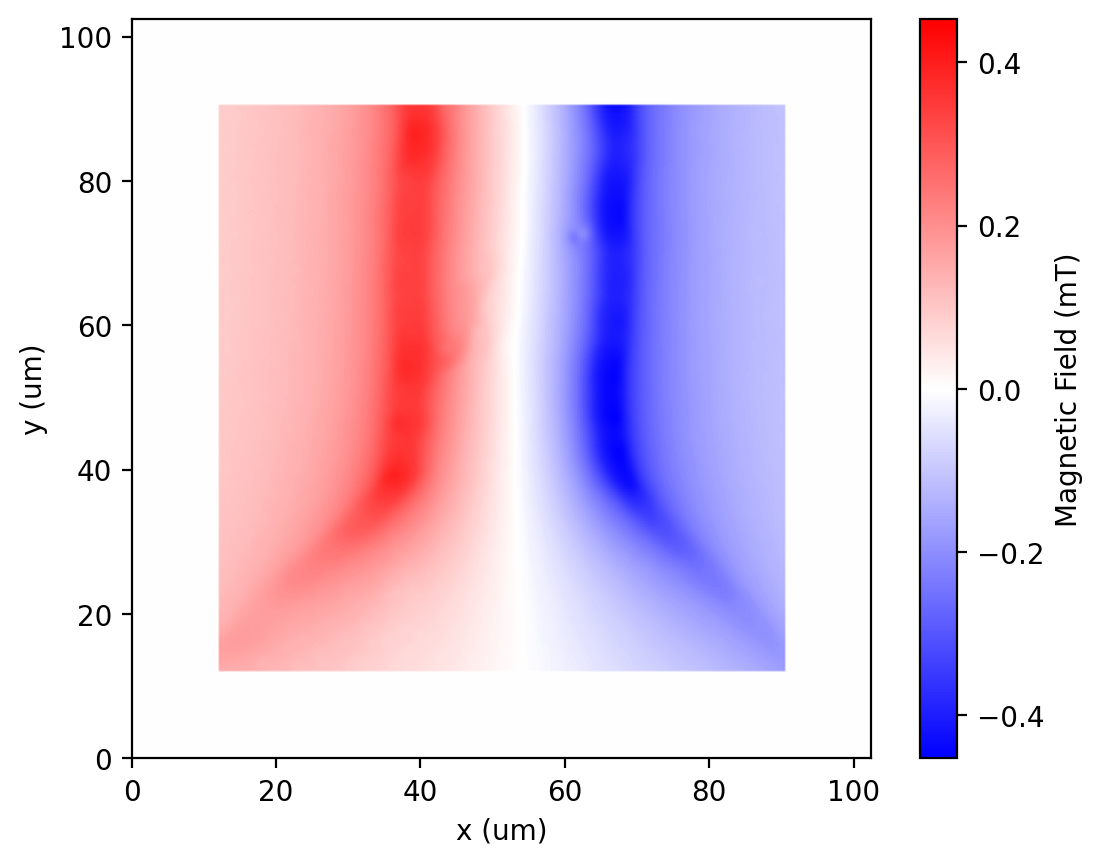

In [133]:
from magrec.method.FCNN import FCNN
from magrec.models.Jxy import Jxy

sensor_theta = 0
sensor_phi = 0 

dx = 0.4
dy = 0.4
height = 0.1
thickness = 0.1

dataset2 = Data()
dataset2.load_data(
       B[2,::] *1e3, 
       dx, 
       dy, 
       height, 
       sensor_theta, 
       sensor_phi, 
       thickness)

dataset2.remove_DC_background()
dataset2.add_hanning_filter(1)
dataset2.crop_data((2,198,2,198))
# dataset.pad_reflective2d()
dataset2.pad_data_to_power_of_two()
dataset2.plot_target()

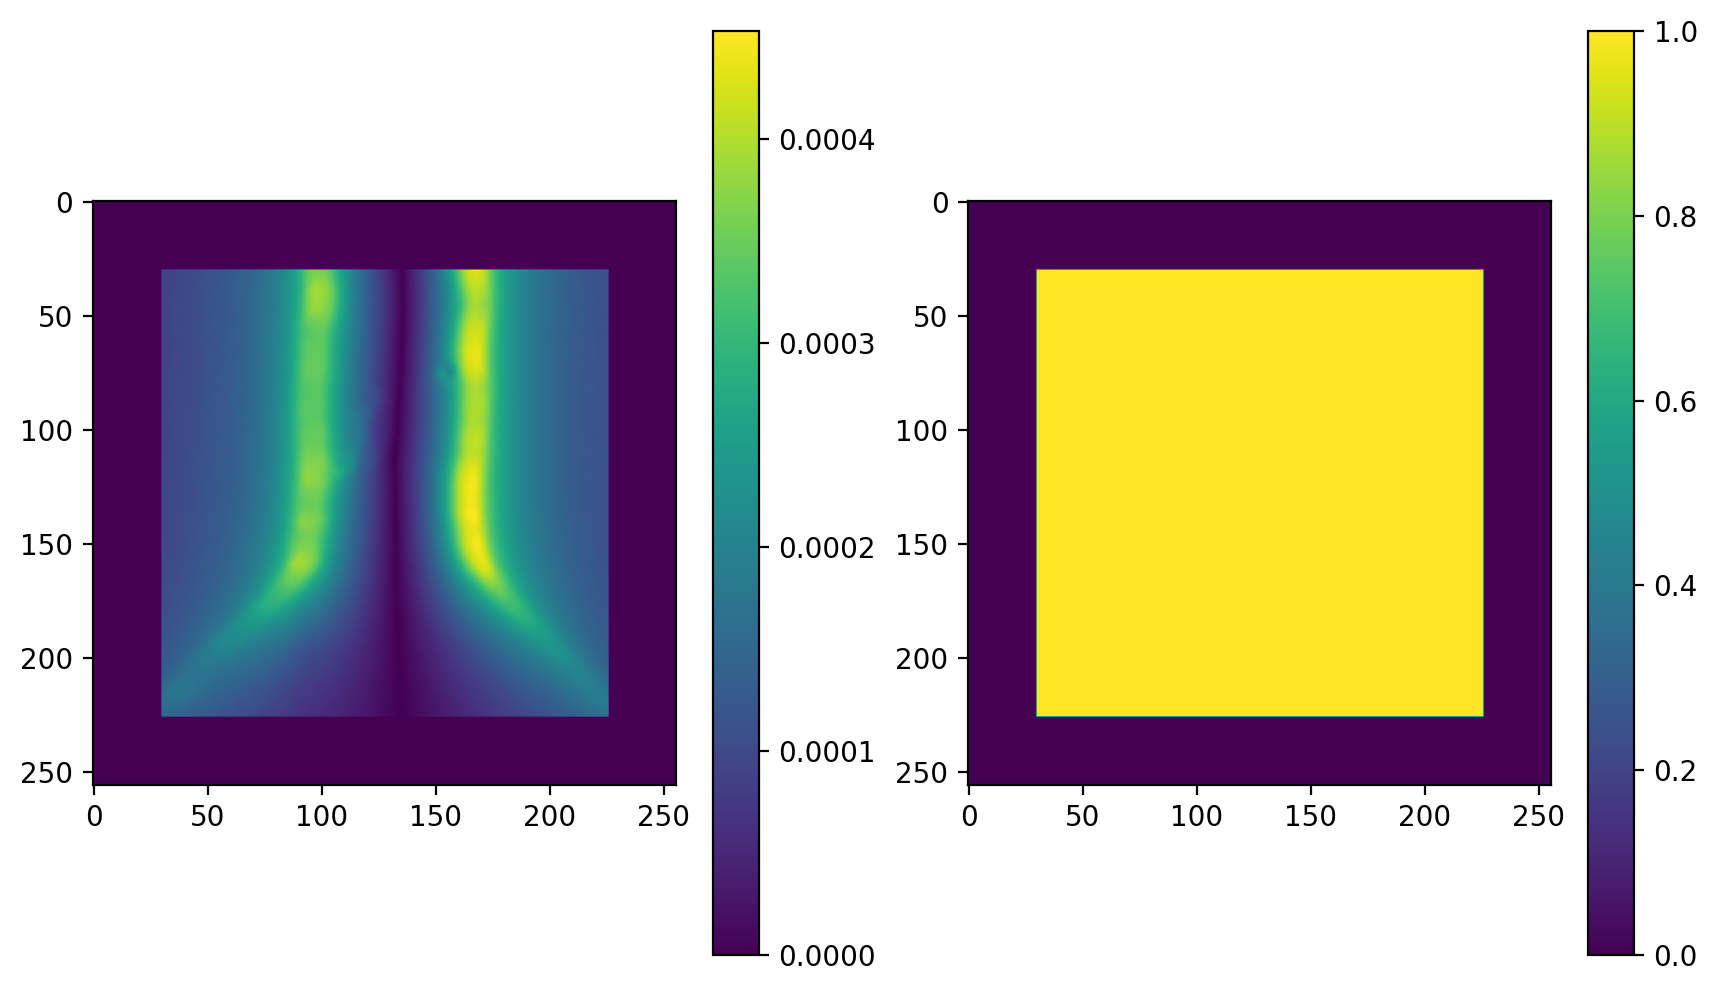

In [134]:
import magrec.image_processing.Masks as Masks
weight1 = Masks.mask_hor_dir(dataset2.target, 0.00005,  plot=True)

# weight2 = Masks.mask_vert_dir(dataset2.target, 0.00001,  plot=True)
weight = weight1

In [138]:
Model = Jxy(dataset2, "MSE")
FittingMethod = FCNN(Model, dataset2)
# FittingMethod.prepare_fit(loss_weight=weight)
FittingMethod.prepare_fit()

Number of sources: 2
Number of targets: 1


In [139]:
FittingMethod.fit(n_epochs=100)

epoch     1 | loss on last mini-batch:  2.22e+04
epoch    11 | loss on last mini-batch:  1.78e+04
epoch    21 | loss on last mini-batch:  1.61e+04
epoch    31 | loss on last mini-batch:  2.72e+03
epoch    41 | loss on last mini-batch:  1.46e+03
epoch    51 | loss on last mini-batch:  6.92e+02
epoch    61 | loss on last mini-batch:  3.42e+02
epoch    71 | loss on last mini-batch:  2.07e+02
epoch    81 | loss on last mini-batch:  1.38e+02
epoch    91 | loss on last mini-batch:  1.02e+02


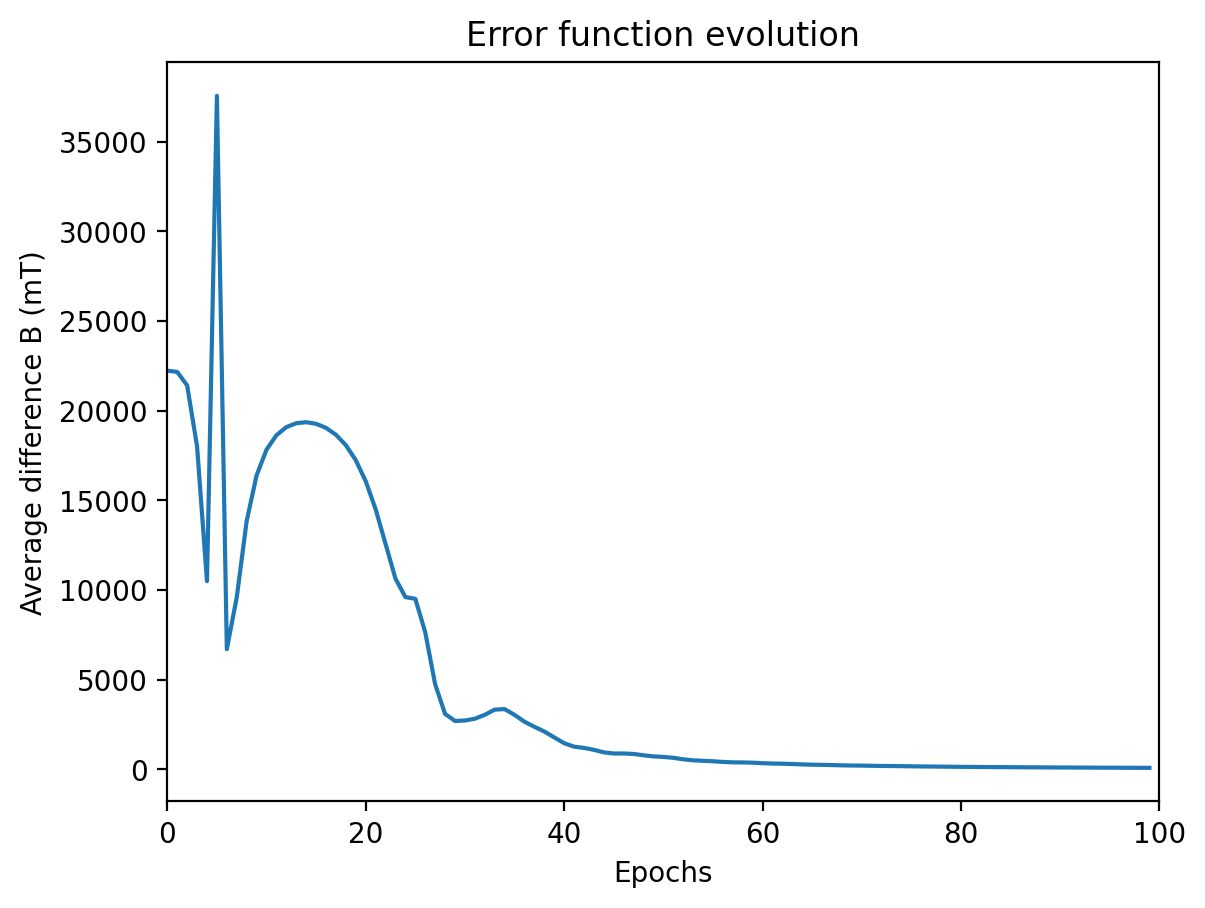

In [140]:
FittingMethod.plot_loss()

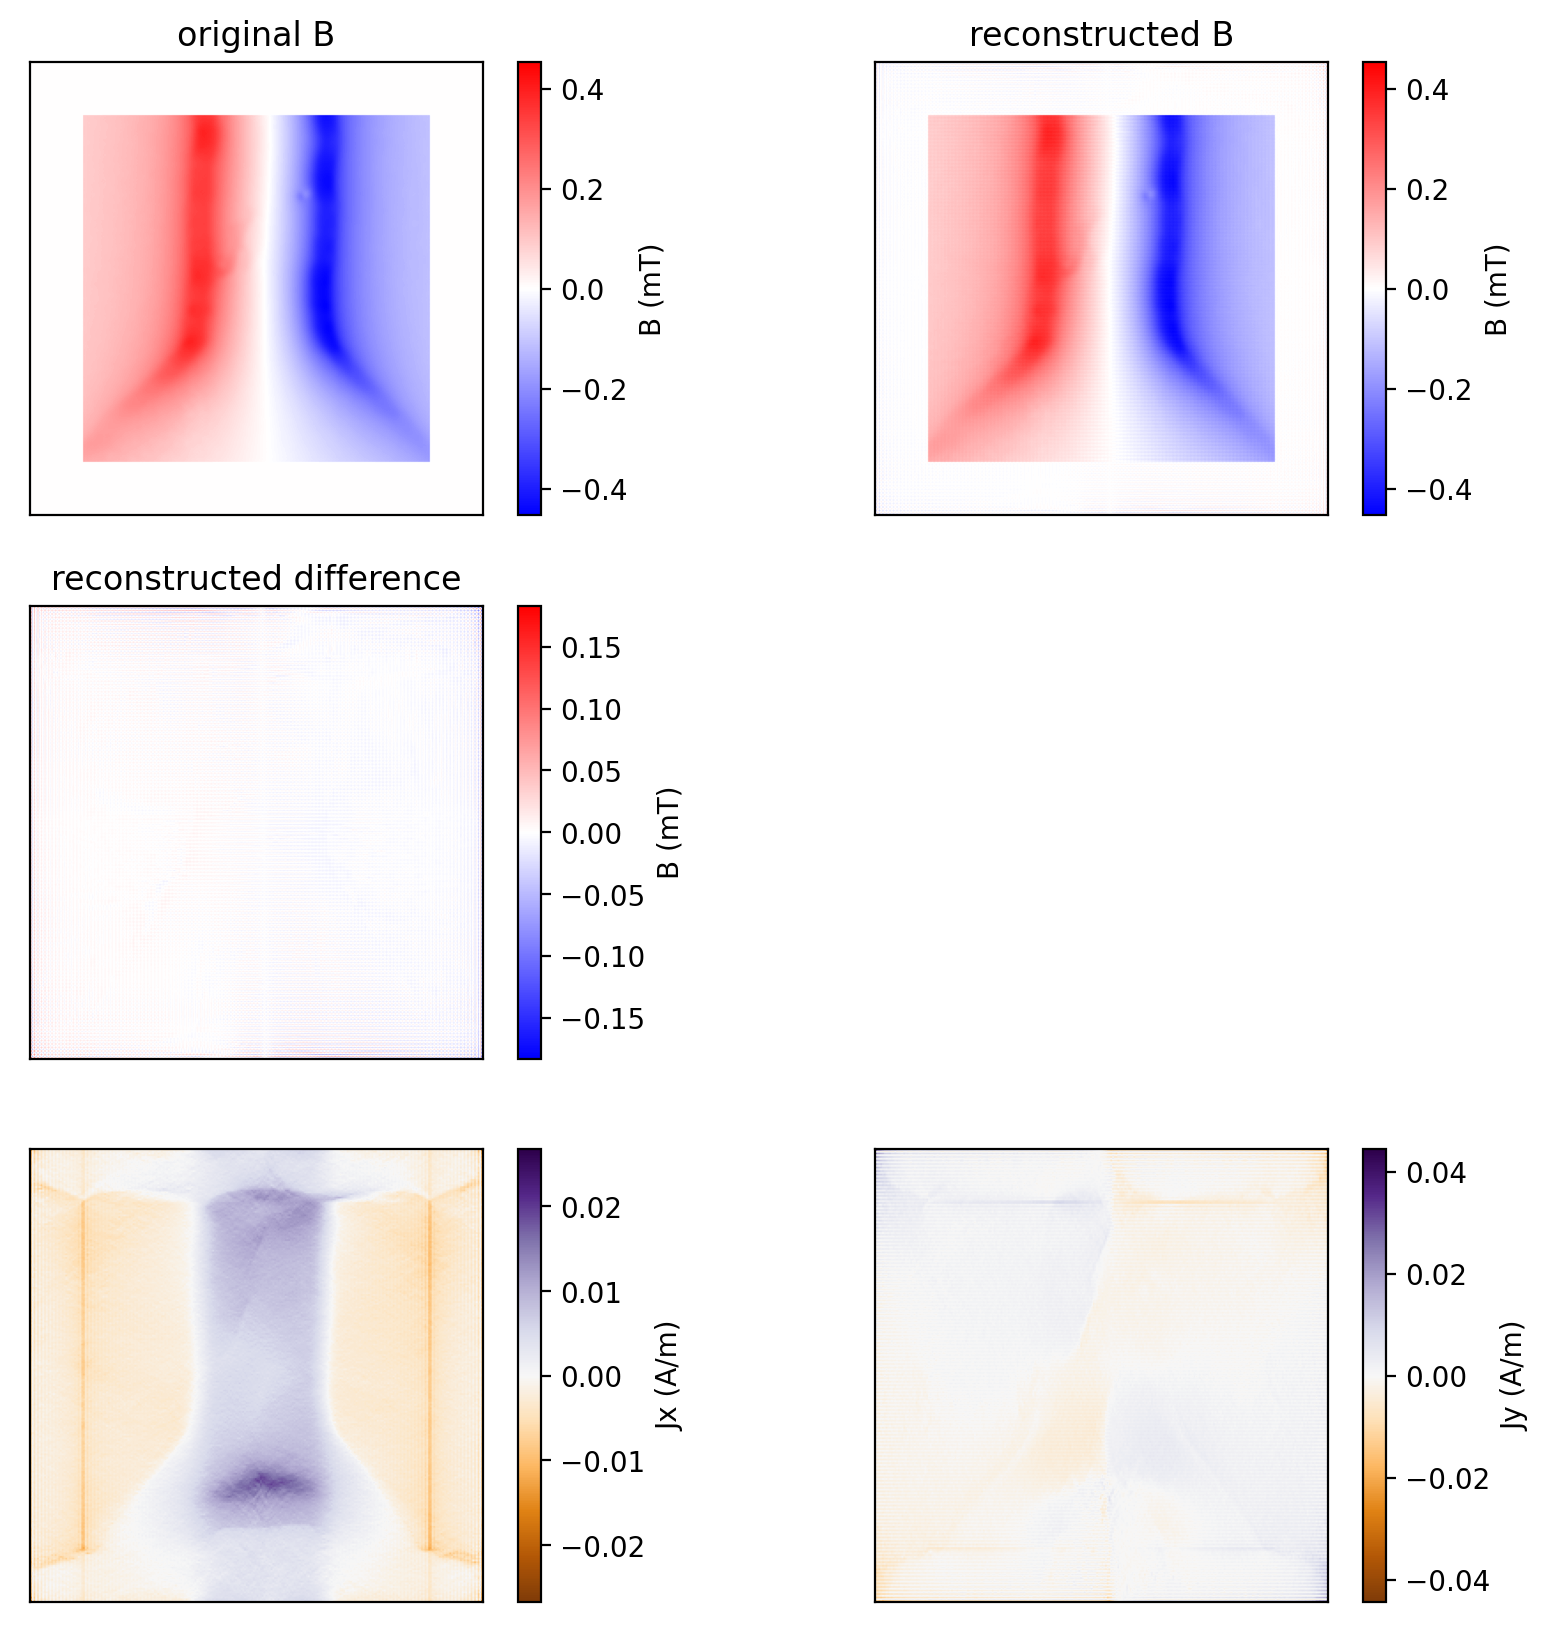

In [141]:
FittingMethod.extract_results(remove_padding=False)
FittingMethod.plot_results()